In [1]:
import tensorflow as tf
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from tensorflow.python.keras import backend as K
#from tensorflow.keras.backend import random_bernoulli as K

In [2]:
#import keras


class DropBlock2D(tf.keras.layers.Layer):
    """See: https://arxiv.org/pdf/1810.12890.pd
    """

    def __init__(self,
                 block_size,
                 keep_prob,
                 sync_channels=False,
                 data_format=None,
                 **kwargs):
        """Initialize the layer.
        :param block_size: Size for each mask block.
        :param keep_prob: Probability of keeping the original feature.
        :param sync_channels: Whether to use the same dropout for all channels.
        :param data_format: 'channels_first' or 'channels_last' (default).
        :param kwargs: Arguments for parent class.
        """
        super(DropBlock2D, self).__init__(**kwargs)
        self.block_size = block_size
        self.keep_prob = keep_prob
        self.sync_channels = sync_channels
        self.data_format = data_format
        self.supports_masking = True
        self.height = self.width = self.ones = self.zeros = None

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            self.height, self.width = input_shape[2], input_shape[3]
        else:
            self.height, self.width = input_shape[1], input_shape[2]
        self.ones = K.ones((self.height, self.width), name='ones')
        self.zeros = K.zeros((self.height, self.width), name='zeros')
        super().build(input_shape)

    def get_config(self):
        config = {'block_size': self.block_size,
                  'keep_prob': self.keep_prob,
                  'sync_channels': self.sync_channels,
                  'data_format': self.data_format}
        base_config = super(DropBlock2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_mask(self, inputs, mask=None):
        return mask

    def compute_output_shape(self, input_shape):
        return input_shape

    def _get_gamma(self):
        """Get the number of activation units to drop"""
        height, width = K.cast(self.height, K.floatx()), K.cast(self.width, K.floatx())
        block_size = K.constant(self.block_size, dtype=K.floatx())
        return ((1.0 - self.keep_prob) / (block_size ** 2)) *\
               (height * width / ((height - block_size + 1.0) * (width - block_size + 1.0)))

    def _compute_valid_seed_region(self):
        positions = K.concatenate([
            K.expand_dims(K.tile(K.expand_dims(K.arange(self.height), axis=1), [1, self.width]), axis=-1),
            K.expand_dims(K.tile(K.expand_dims(K.arange(self.width), axis=0), [self.height, 1]), axis=-1),
        ], axis=-1)
        half_block_size = self.block_size // 2
        valid_seed_region = K.switch(
            K.all(
                K.stack(
                    [
                        positions[:, :, 0] >= half_block_size,
                        positions[:, :, 1] >= half_block_size,
                        positions[:, :, 0] < self.height - half_block_size,
                        positions[:, :, 1] < self.width - half_block_size,
                    ],
                    axis=-1,
                ),
                axis=-1,
            ),
            self.ones,
            self.zeros,
        )
        return K.expand_dims(K.expand_dims(valid_seed_region, axis=0), axis=-1)

    def _compute_drop_mask(self, shape):
        mask = K.random_binomial(shape, p=self._get_gamma())
        mask *= self._compute_valid_seed_region()
        mask = tf.keras.layers.MaxPool2D(
            pool_size=(self.block_size, self.block_size),
            padding='same',
            strides=1,
            data_format='channels_last',
        )(mask)
        return 1.0 - mask

    def call(self, inputs, training=None):

        def dropped_inputs():
            outputs = inputs
            if self.data_format == 'channels_first':
                outputs = K.permute_dimensions(outputs, [0, 2, 3, 1])
            shape = K.shape(outputs)
            if self.sync_channels:
                mask = self._compute_drop_mask([shape[0], shape[1], shape[2], 1])
            else:
                mask = self._compute_drop_mask(shape)
            outputs = outputs * mask *\
                (K.cast(K.prod(shape), dtype=K.floatx()) / K.sum(mask))
            if self.data_format == 'channels_first':
                outputs = K.permute_dimensions(outputs, [0, 3, 1, 2])
            return outputs

        return K.in_train_phase(dropped_inputs, inputs, training=training)

In [3]:
def build_dropout_model():
        # Build the network of vgg for 10 classes with massive dropout and weight decay as described in the paper.

        model = tf.keras.Sequential()
        weight_decay = 0.0005
        x_shape = (32,32,3)
        num_classes=10
        
        model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same',input_shape=x_shape,
                         kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(0.4))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same',kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.BatchNormalization())

        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

        model.add(tf.keras.layers.Dropout(0.4))

        

        model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same',kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(0.4))

       
        model.add(tf.keras.layers.Conv2D(512, (3, 3), padding='same',kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(0.4))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Conv2D(512, (3, 3), padding='same',kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(0.4))
       
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(512,kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(tf.keras.layers.Dense(num_classes))
        model.add(tf.keras.layers.Activation('softmax'))
        return model


In [4]:
def build_droblock_model():
        # Build the network of vgg for 10 classes with massive dropout and weight decay as described in the paper.

        model = tf.keras.Sequential()
        weight_decay = 0.0005
        x_shape = (32,32,3)
        num_classes=10
        
        model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same',input_shape=x_shape,
                         kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(DropBlock2D(block_size=3, keep_prob=0.75))
        
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(DropBlock2D(block_size=3, keep_prob=0.2))
        model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same',kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(DropBlock2D(block_size=3, keep_prob=0.75))

        model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same',kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(DropBlock2D(block_size=4, keep_prob=0.8))

       

        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))


        model.add(tf.keras.layers.Conv2D(512, (3, 3), padding='same',kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(DropBlock2D(block_size=3, keep_prob=0.8))

        

        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))


        model.add(tf.keras.layers.Conv2D(512, (3, 3), padding='same',kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(DropBlock2D(block_size=3, keep_prob=0.8))

      

        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(DropBlock2D(block_size=3, keep_prob=0.9))

        model.add(tf.keras.layers.Flatten())
        
        model.add(tf.keras.layers.Dense(512,kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
        model.add(tf.keras.layers.Activation('relu'))
        #model.add(DropBlock2D(block_size=4, keep_prob=0.2))
        model.add(tf.keras.layers.BatchNormalization())

      
        model.add(tf.keras.layers.Dense(num_classes))
        model.add(tf.keras.layers.Activation('softmax'))
        return model


In [5]:

model_dropout = build_dropout_model()
model_dropblock = build_droblock_model()

Instructions for updating:
Use `tf.keras.backend.random_bernoulli` instead.


In [6]:
model_dropout.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 128)       0

In [7]:
model_dropblock.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
drop_block2d (DropBlock2D)   (None, 32, 32, 64)        2048      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
drop_block2d_1 (DropBlock2D) (None, 16, 16, 64)        512       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)      

In [8]:
def normalize(X_train,X_test):
        #this function normalize inputs for zero mean and unit variance
        # it is used when training a model.
        # Input: training set and test set
        # Output: normalized training set and test set according to the trianing set statistics.
        mean = np.mean(X_train,axis=(0,1,2,3))
        std = np.std(X_train, axis=(0, 1, 2, 3))
        X_train = (X_train-mean)/(std+1e-7)
        X_test = (X_test-mean)/(std+1e-7)
        return X_train, X_test

In [9]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train, x_test = normalize(x_train, x_test)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [10]:
opt = tf.keras.optimizers.Adam(lr=0.001)


In [11]:
learning_rate = 0.1
lr_decay = 1e-6
   
sgd = tf.keras.optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)


In [12]:
model_dropout.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])


In [13]:
#from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_dropout = tf.keras.callbacks.ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', 
                                                verbose=1, save_best_only=True, save_weights_only=False, 
                                                mode='auto', save_freq='epoch')
early =  tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                          min_delta=0, 
                                          patience=20, 
                                          verbose=1, mode='auto')


In [14]:
x_train.shape

(50000, 32, 32, 3)

In [15]:
history = model_dropout.fit(x_train, y_train, epochs=20, batch_size=64, 
                    validation_data=(x_test, y_test), 
                    verbose=1,
                    validation_steps=10,
                    validation_batch_size=32,
                    callbacks=[checkpoint_dropout,early])

Epoch 1/20
782/782 [==============================] - ETA: 0s - loss: 2.5825 - accuracy: 0.3887 E
Epoch 00001: val_accuracy improved from -inf to 0.42500, saving model to vgg16_1.h5
782/782 [==============================] - 13s 16ms/step - loss: 2.5825 - accuracy: 0.3887 - val_loss: 3.4260 - val_accuracy: 0.4250
Epoch 2/20
780/782 [============================>.] - ETA: 0s - loss: 1.9203 - accuracy: 0.5392
Epoch 00002: val_accuracy improved from 0.42500 to 0.56563, saving model to vgg16_1.h5
782/782 [==============================] - 12s 16ms/step - loss: 1.9200 - accuracy: 0.5394 - val_loss: 2.2193 - val_accuracy: 0.5656
Epoch 3/20
780/782 [============================>.] - ETA: 0s - loss: 1.6645 - accuracy: 0.6225
Epoch 00003: val_accuracy did not improve from 0.56563
782/782 [==============================] - 12s 15ms/step - loss: 1.6646 - accuracy: 0.6224 - val_loss: 2.4519 - val_accuracy: 0.5469
Epoch 4/20
779/782 [============================>.] - ETA: 0s - loss: 1.6000 - accura

In [16]:
model_dropblock.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
checkpoint_dropblock = tf.keras.callbacks.ModelCheckpoint("dropblock_model_2.h5", monitor='val_accuracy', 
                                                verbose=1, save_best_only=True, save_weights_only=False, 
                                                mode='auto', save_freq='epoch')
history_2 = model_dropblock.fit(x_train, y_train, epochs=20, batch_size=64, 
                    validation_data=(x_test, y_test), 
                    verbose=1,
                    validation_steps=10,
                    validation_batch_size=32,
                    callbacks=[checkpoint_dropblock,early])

Epoch 1/20
782/782 [==============================] - ETA: 0s - loss: 3.1731 - accuracy: 0.4520
Epoch 00001: val_accuracy improved from -inf to 0.48438, saving model to dropblock_model_2.h5
782/782 [==============================] - 25s 32ms/step - loss: 3.1731 - accuracy: 0.4520 - val_loss: 2.2925 - val_accuracy: 0.4844
Epoch 2/20
782/782 [==============================] - ETA: 0s - loss: 1.7659 - accuracy: 0.6197
Epoch 00002: val_accuracy improved from 0.48438 to 0.62500, saving model to dropblock_model_2.h5
782/782 [==============================] - 25s 32ms/step - loss: 1.7659 - accuracy: 0.6197 - val_loss: 1.6834 - val_accuracy: 0.6250
Epoch 3/20
782/782 [==============================] - ETA: 0s - loss: 1.5240 - accuracy: 0.6918
Epoch 00003: val_accuracy improved from 0.62500 to 0.67813, saving model to dropblock_model_2.h5
782/782 [==============================] - 25s 32ms/step - loss: 1.5240 - accuracy: 0.6918 - val_loss: 1.5543 - val_accuracy: 0.6781
Epoch 4/20
781/782 [=====

In [17]:
for key in history.history:
  print(key)

loss
accuracy
val_loss
val_accuracy


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

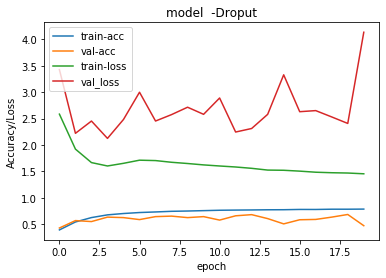

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model  -Droput')
plt.ylabel('Accuracy/Loss')
plt.xlabel('epoch')
plt.legend(['train-acc', 'val-acc', 'train-loss', 'val_loss'], loc='upper left')
plt.show()


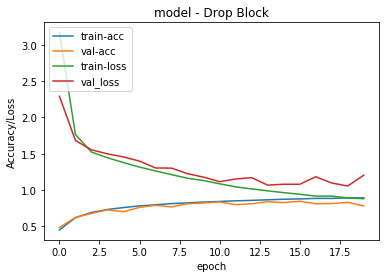

In [22]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model - Drop Block')
plt.ylabel('Accuracy/Loss')
plt.xlabel('epoch')
plt.legend(['train-acc', 'val-acc', 'train-loss', 'val_loss'], loc='upper left')
plt.show()


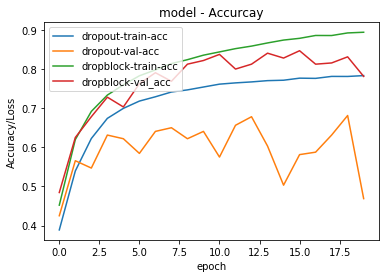

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model - Accurcay')
plt.ylabel('Accuracy/Loss')
plt.xlabel('epoch')
plt.legend(['dropout-train-acc', 'dropout-val-acc', 'dropblock-train-acc', 'dropblock-val_acc'], loc='upper left')
plt.show()

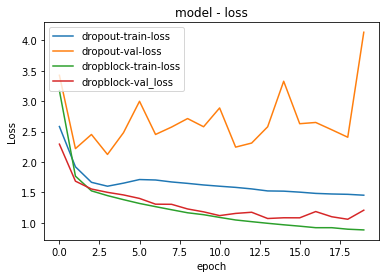

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model - loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['dropout-train-loss', 'dropout-val-loss', 'dropblock-train-loss', 'dropblock-val_loss'], loc='upper left')
plt.show()